In [1]:
from fastai import *
from fastai.tabular import *
from fastai.text import *

In [2]:
%matplotlib inline
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re
from collections import Counter
import random

In [3]:
path = '/floyd/home/notebooks'
data_path = '/floyd/home/data'
model_path = '/floyd/home/models'

In [4]:
df1 = pd.read_csv(data_path +'/targets.csv', index_col=0)
df2 = pd.read_csv(data_path + '/subj_data.csv', index_col=0)
data = pd.concat([df1,df2],axis = 1)

In [5]:
len(data)

136993

In [6]:
data.head()

,outcome,target,service,target2,discharge,target3,dispo,SubjectiveNotes,MedicalHistory,pmhx
0,discharge,1,discharge,1,discharge,1,NaN,NaN,NaN,NaN
1,discharge,1,discharge,1,discharge,1,NaN,NaN,NaN,NaN
2,discharge,1,discharge,1,discharge,1,NaN,NaN,NaN,NaN
3,discharge,1,discharge,1,discharge,1,NaN,NaN,NaN,NaN
4,discharge,1,discharge,1,discharge,1,NaN,NaN,NaN,NaN


In [7]:
data.dropna(subset = ['SubjectiveNotes'], inplace = True)
len(data)

110457

In [8]:
for note in list(data['SubjectiveNotes'])[:10]:
    print (note)

patient states that she feels shaky.  patient denies any pain.
patient states no pain.
denied chest pain
Denies pain. Eating ED lunch at triage
patient complains of pain  on the left wrist and left ankle , no obvious deformity , with minor laceration  in between left thumb, and  2nd digit left finger .
The patient states his pain is manageable. Still shivering-patient was laying on a cold concrete floor. Denies any other injuries other then the left leg.
As per the police the patient-was having an agressive altercation with his mother.  The patient was to have mentioned to a call taker that he was suicidal.  The patient has a his of autism and some behaviour issues.
patient states feels weak, complains of pain to feet x 3-4 days, nauseated
complains of pain of frontal headache, continues to complains of generalized body pain.
patient states feels pain is behind his lungs. patient states urine is darker than normal. states discomfort when voiding.


In [16]:
len(data)

110457

In [23]:
#this is to clean the text in the subjective notes column (a little bit)
def fixencode(s):
    if pd.isnull(s):
        s = "None"
    s=s.replace('<LT><LF>',',')
    s=s.replace('Pt.', 'patient')
    s=s.replace('Pt', 'patient')
    s= s.replace('pt.', 'patient')
    s=s.replace('pt', 'patient')
    s = s.replace('y/o', 'year old')
    s = s.replace('c/o', 'complains of')
    s = s.replace('C/o', 'complains of')
    return s

In [25]:
data['SubjectiveNotes'] = data.SubjectiveNotes.map(fixencode)

In [26]:
for note in list(data['SubjectiveNotes'])[:10]:
    print (note)

patient states that she feels shaky.  patient denies any pain.
patient states no pain.
denied chest pain
Denies pain. Eating ED lunch at triage
patient complains of pain  on the left wrist and left ankle , no obvious deformity , with minor laceration  in between left thumb, and  2nd digit left finger .
The patient states his pain is manageable. Still shivering-patient was laying on a cold concrete floor. Denies any other injuries other then the left leg.
As per the police the patient-was having an agressive altercation with his mother.  The patient was to have mentioned to a call taker that he was suicidal.  The patient has a his of autism and some behaviour issues.
patient states feels weak, complains of pain to feet x 3-4 days, nauseated
complains of pain of frontal headache, continues to complains of generalized body pain.
patient states feels pain is behind his lungs. patient states urine is darker than normal. states discomfort when voiding.


In [27]:
outcome_count = Counter(data['outcome']); outcome_count

Counter({'discharge': 99885, 'sadmit': 1567, 'madmit': 8361, 'ICU': 644})

In [28]:
service_count = Counter(data['service']); service_count

Counter({'discharge': 99885, 'sadmit': 1829, 'madmit': 8549, 'ICU': 194})

In [40]:
#this is a language model databunch from the entire dataset
data_lm = load_data(model_path,'large_lm')

In [26]:
data_clas_full = (TextList.from_df(data, cols='subj',vocab=data_lm.vocab)
                   .split_by_rand_pct(0.2)
                   .label_from_df(cols = 'outcome')
                   .databunch())

saving the large classifier databunch...

In [28]:
data_clas_full.save(model_path + '/full_clas_db')

Now on to training the classifier

In [33]:
f1 = FBeta(beta=1, average = 'weighted')
def train_triage_classifier(encoder_name, datac = data_clas_full, datal = data_lm, 
                            mets = [accuracy,f1], num_cycles = 1, lr = 1e-2, drop_mult = 0.5):
    model = text_classifier_learner(datac, metrics = mets, arch = AWD_LSTM, drop_mult=drop_mult)
    model.load_encoder(model_path + '/' + encoder_name)
    model.fit_one_cycle(num_cycles, lr, moms=(0.8,0.7))
    model.freeze_to(-2)
    model.fit_one_cycle(num_cycles, slice(lr/(2.6**4),lr), moms=(0.8,0.7))
    model.freeze_to(-3)
    model.fit_one_cycle(num_cycles, slice((lr/2)/(2.6**4),(lr/2)), moms=(0.8,0.7))
    model.unfreeze()
    model.fit_one_cycle(num_cycles*5, slice((lr/100)/(2.6**4),(lr/100)), moms=(0.8,0.7))
    model.recorder.plot_losses()
    return model

#### training classifier (I am using the full dataset here)

epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.325037,0.326482,0.903083,0.859870,04:05


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.333564,0.319306,0.903490,0.862087,04:52


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.310981,0.316502,0.903762,0.862217,07:25


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.309803,0.315701,0.903988,0.863279,10:13
1,0.304975,0.315680,0.903762,0.863265,10:02
2,0.313507,0.315853,0.903898,0.862960,10:17
3,0.302416,0.315710,0.903762,0.863609,10:03
4,0.313738,0.315649,0.904079,0.863228,09:34


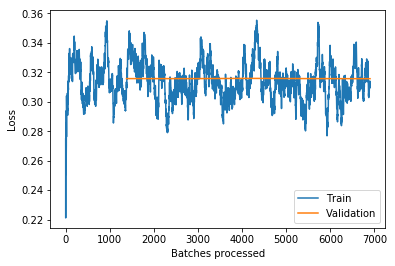

In [41]:
sent_learn = train_triage_classifier('edsent_v2_enc2', datac = data_clas_full, num_cycles = 1, lr = 1e-3)

In [42]:
preds, targets = sent_learn.get_preds(DatasetType.Valid) 
predictions = np.argmax(preds, axis = 1) 

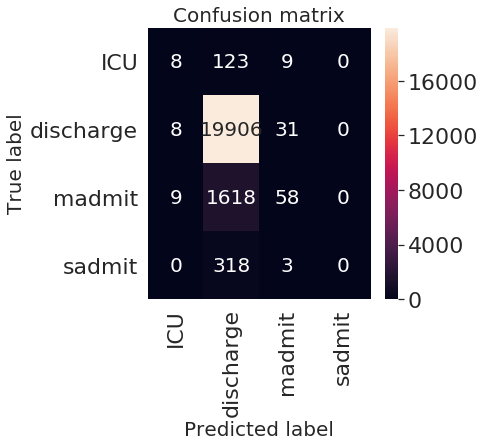

In [44]:
%matplotlib inline
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale=2)

LABELS = data_clas_full.classes

confusion_matrix = metrics.confusion_matrix(targets, predictions)

plt.figure(figsize=(5, 5))
sns.heatmap(confusion_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d", annot_kws={"size": 20});
plt.title("Confusion matrix", fontsize=20)
plt.ylabel('True label', fontsize=20)
plt.xlabel('Predicted label', fontsize=20)
plt.show()

In [47]:
sent_learn.save(model_path + '/edtriage2')

so the results above show high accuracy and f-score, but very few admission predictions

now gonna train longer and see what happens

In [46]:
data_clas_full2 = (TextList.from_df(data, cols='subj',vocab=data_lm.vocab)
                   .split_by_rand_pct(0.2)
                   .label_from_df(cols = 'service')
                   .databunch())

epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.323382,0.318309,0.904214,0.864396,03:57
1,0.290085,0.306193,0.904984,0.863604,03:54
2,0.337687,0.303845,0.904984,0.863285,04:05


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.306796,0.305917,0.904577,0.863555,04:51
1,0.314900,0.300065,0.905074,0.865789,04:39
2,0.276908,0.299801,0.905074,0.866325,04:46


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.284210,0.299914,0.905074,0.868041,07:31
1,0.286468,0.299472,0.905165,0.866765,07:31
2,0.283946,0.298888,0.904893,0.867925,07:32


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.270205,0.298970,0.904622,0.867437,10:06
1,0.288500,0.299180,0.905165,0.866894,09:40
2,0.294971,0.298831,0.905029,0.867654,09:57
3,0.271473,0.298987,0.904622,0.868204,09:34
4,0.276894,0.298771,0.904848,0.867567,10:16
5,0.281706,0.298766,0.904667,0.868109,10:07
6,0.298027,0.298452,0.905346,0.867719,10:08
7,0.272918,0.298930,0.904577,0.868088,10:19
8,0.294623,0.298981,0.905210,0.867319,09:41
9,0.301512,0.298809,0.904984,0.867493,09:39


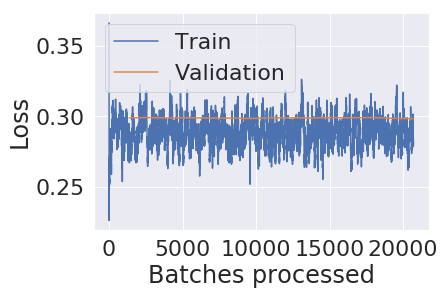

In [48]:
sent_learn = train_triage_classifier('edsent_v2_enc2', datac = data_clas_full2, num_cycles = 3, lr = 1e-3)

In [49]:
sent_learn.save(model_path + '/edtriage3')

In [50]:
preds, targets = sent_learn.get_preds(DatasetType.Valid) 
predictions = np.argmax(preds, axis = 1) 

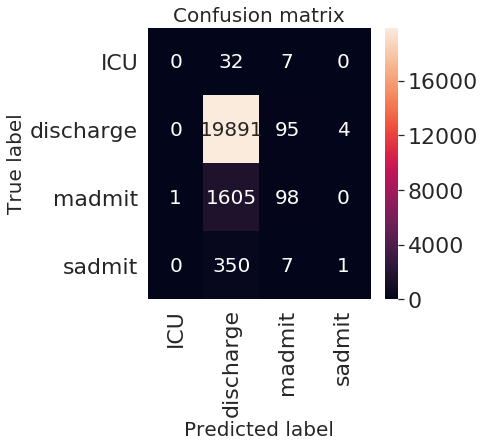

In [51]:
confusion_matrix = metrics.confusion_matrix(targets, predictions)

plt.figure(figsize=(5, 5))
sns.heatmap(confusion_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d", annot_kws={"size": 20});
plt.title("Confusion matrix", fontsize=20)
plt.ylabel('True label', fontsize=20)
plt.xlabel('Predicted label', fontsize=20)
plt.show()

this was a little worse because it overfit the data

now it's time to make a balanced dataset

In [30]:
dc_count = Counter(data['discharge']); dc_count

Counter({'discharge': 99885, 'admit': 10572})

In [31]:
dc_df = data[data['discharge']=='discharge']

In [32]:
ad_df = data[data['discharge']=='admit']

In [34]:
len(ad_df), len(dc_df)

(10572, 99885)

In [35]:
ltd_dc_df = dc_df.sample(n=10572,random_state=42)

In [36]:
len(ltd_dc_df)

10572

In [37]:
bal_df = ltd_dc_df.append(ad_df)

In [38]:
len(bal_df)

21144

In [39]:
dc_count = Counter(bal_df['discharge']); dc_count

Counter({'discharge': 10572, 'admit': 10572})

In [41]:
data_clas_bal = (TextList.from_df(bal_df, cols='SubjectiveNotes',vocab=data_lm.vocab)
                   .split_by_rand_pct(0.1)
                   .label_from_df(cols = 'discharge')
                   .databunch())

In [47]:
def train_triage_classifier(encoder_name, datac, datal = data_lm, 
                            f1_type = None, num_cycles = 1, lr = 1e-2, drop_mult = 0.5):
    f1 = FBeta(beta=1, average = f1_type)
    model = text_classifier_learner(datac, metrics = [accuracy,f1], arch = AWD_LSTM, drop_mult=drop_mult)
    model.load_encoder(model_path + '/' + encoder_name)
    model.fit_one_cycle(num_cycles, lr, moms=(0.8,0.7))
    model.freeze_to(-2)
    model.fit_one_cycle(num_cycles, slice(lr/(2.6**4),lr), moms=(0.8,0.7))
    model.freeze_to(-3)
    model.fit_one_cycle(num_cycles, slice((lr/2)/(2.6**4),(lr/2)), moms=(0.8,0.7))
    model.unfreeze()
    model.fit_one_cycle(num_cycles*5, slice((lr/100)/(2.6**4),(lr/100)), moms=(0.8,0.7))
    model.recorder.plot_losses()
    return model

#### training classifier (I am using the balanced dataset here)

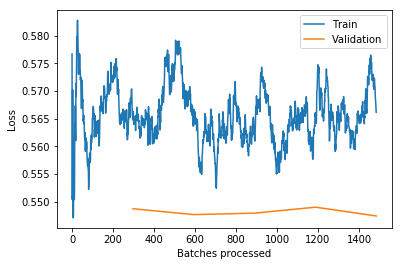

In [45]:
sent_learn = train_triage_classifier('edsent_v2_enc2', datac = data_clas_bal, num_cycles = 1, lr = 1e-3)

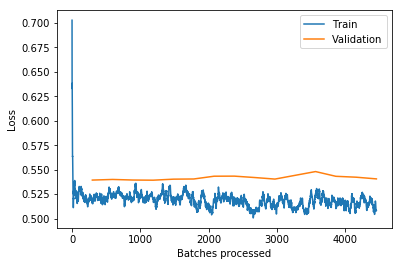

In [48]:
sent_learn = train_triage_classifier('edsent_v2_enc2', datac = data_clas_bal, num_cycles = 3, lr = 1e-2, drop_mult = 0.7)

In [49]:
sent_learn.save(model_path + '/balanced_subj_ed_clas.pth')

In [50]:
preds, targets = sent_learn.get_preds(DatasetType.Valid) 
predictions = np.argmax(preds, axis = 1) 

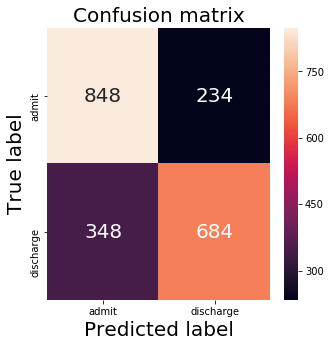

In [52]:
confusion_matrix = metrics.confusion_matrix(targets, predictions)

LABELS = data_clas_bal.classes
plt.figure(figsize=(5, 5))
sns.heatmap(confusion_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d", annot_kws={"size": 20});
plt.title("Confusion matrix", fontsize=20)
plt.ylabel('True label', fontsize=20)
plt.xlabel('Predicted label', fontsize=20)
plt.show()